In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
from models.flow import Flow
# from models.fair import BinaryFair
from models.my_fair import BinaryFair
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from models.galton import Galton
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2


## Generate Split Data 

### Baseline High-Res Simulator 

In [2]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

data, labels, context = gen_galton_data(2/3, 100, sigma=0.4)
data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_context_train = TensorDataset(data_train, context_train) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

In [14]:
#Get label and adversarial accuracy on raw data
#TODO: Calculate analytic accuracy based on overlap of (Gaussian?) distributions
label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test)
adv_acc = adversarial_classifier.accuracy(data_test, context_test)

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", adv_acc)


100%|██████████| 10000/10000 [00:19<00:00, 502.75it/s]

Label accuracy: 0.6175000071525574 Adversarial accuracy: 0.5839999914169312


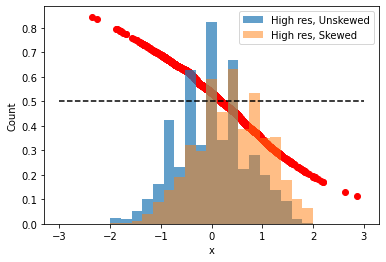

In [4]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="High res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20), alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), label_classifier.forward(data_test).sigmoid().detach().numpy(), color='red') #Sigmoid for density comparison

plt.plot(np.linspace(-3,3,100), 0.5*np.ones(100), 'k--')

plt.show()

## Introducing Fair Flows

### Probability Flow

In [5]:
#Treating this probability flow as part of the data generation process. Samples from p_0, p_1
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [6]:
data_set_context_train = TensorDataset(data_train, context_train) #For probability flow, learn distributions conditioned on context
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

In [7]:
n_steps_prob = 4000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, context = next(iter(data_generator_context_train))
    context=context.unsqueeze(1)

    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 4000/4000 [00:54<00:00, 73.17it/s]


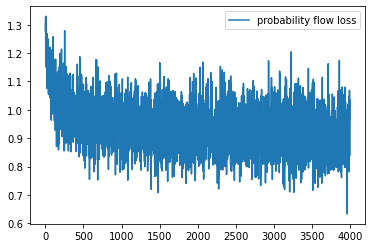

In [19]:
plt.plot(probability_loss, label="probability flow loss")
plt.legend()
plt.show()

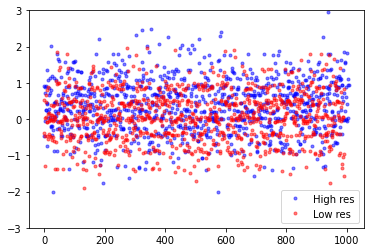

In [10]:
plt.plot(data_test[context_test==1],'b.',label="High res", alpha=0.5)
plt.plot(data_test[context_test==0], 'r.', label="Low res", alpha=0.5)
plt.ylim(-3, 3)
plt.legend()
plt.show()

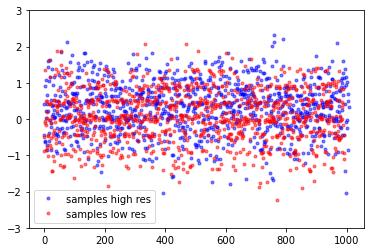

In [11]:
samples = probability_flow._sample(num_samples=1, context=context_test.unsqueeze(1))
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==1], 'b.', alpha=0.5, label="samples high res")
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==0], 'r.', alpha=0.5, label="samples low res")
plt.ylim(-3, 3)
plt.legend()
plt.show()

### Fair Normalizing Flows

In [30]:
label_0_train_generator, label_1_train_generator, label_0_test_generator, label_1_test_generator = get_fair_generators(data_train, labels_train, context_train, data_test, labels_test, context_test)

In [31]:
#Create and train fair normalizing flows
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    Fair.fit(label_0_train_generator, label_1_train_generator, probability_flow, n_steps=10000) #4000 is good for now

    Fairs.append(Fair)


100%|██████████| 10000/10000 [16:18<00:00, 10.22it/s]


In [32]:
#Calculate Statistical Distances
stat_dists = []
for fair in Fairs:
    stat_dist, _, _ = fair.optimal_adversary(label_0_test_generator, label_1_test_generator, probability_func=probability_flow)
    stat_dists.append(abs(stat_dist)) #? why is the statistical distance negative? Should go over this calculation again to see if this makes sense
print(stat_dists)

[tensor(0.9095), tensor(0.2472), tensor(0.2574), tensor(0.0163), tensor(0.0224)]


In [13]:
#Calculate Statistical Distances
stat_dists = []
for fair in Fairs:
    stat_dist, _, _ = fair.optimal_adversary(label_0_test_generator, label_1_test_generator, probability_func=probability_flow)
    stat_dists.append(abs(stat_dist)) #? why is the statistical distance negative? Should go over this calculation again to see if this makes sense
print(stat_dists)

[tensor(0.8927), tensor(0.2993), tensor(0.1471), tensor(0.0306), tensor(0.)]


In [33]:
#Calculate embedded label accuracy and adversarial accuracy
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train, context_train, data_test, labels_test, context_test, fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator)
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))

100%|██████████| 10000/10000 [00:15<00:00, 646.72it/s]


In [34]:
print("embedded label accuracy: ", embedded_label_accs, "\n embedded adversary accuracy: ", adversary_accs)

embedded label accuracy:  [0.6169999837875366, 0.6175000071525574, 0.6169999837875366, 0.6175000071525574, 0.6159999966621399] 
 embedded adversary accuracy:  [0.5669999718666077, 0.5665000081062317, 0.6159999966621399, 0.6004999876022339, 0.6294999718666077]


In [15]:
#I believe these should be the same for alpha=1, complete correlation.
print("embedded label accuracy: ", embedded_label_accs, "\n embedded adversary accuracy: ", adversary_accs)

embedded label accuracy:  [0.6669999957084656, 0.5820000171661377, 0.5705000162124634, 0.5494999885559082, 0.49000000953674316] 
 embedded adversary accuracy:  [0.6044999957084656, 0.5105000138282776, 0.4894999861717224, 0.5205000042915344, 0.4894999861717224]


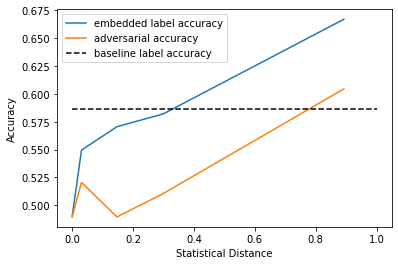

In [20]:
plt.plot(stat_dists, embedded_label_accs, label='embedded label accuracy')
plt.plot(stat_dists, adversary_accs, label='adversarial accuracy')

plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')

plt.xlabel('Statistical Distance')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


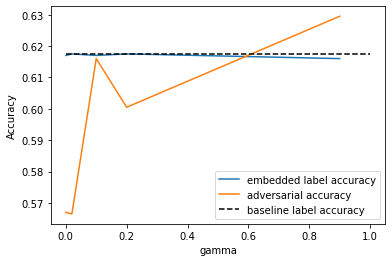

In [35]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')

plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

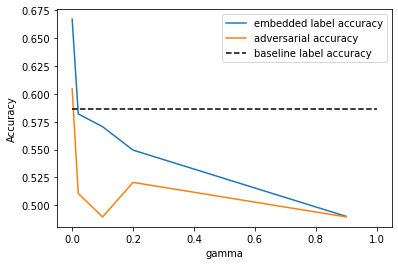

In [21]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')

plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Look at single gamma

In [80]:
Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=0.9
                    )
Fair.fit(label_0_train_generator, label_1_train_generator, probability_flow, n_steps=4000) #4000 is good for now


100%|██████████| 4000/4000 [05:15<00:00, 12.69it/s]


In [93]:
embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train, context_train, data_test, labels_test, context_test, Fair)

adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
adv_classifier.fit(embedding_context_generator)
embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
embedded_label_classifier.fit(embedding_labels_generator)

print((embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test)))
print((adv_classifier.accuracy(embedding_data_test, embedding_context_test)))

 15%|█▌        | 1545/10000 [00:02<00:13, 641.82it/s]

In [91]:
with torch.no_grad():
    print(Fair.flow0._fair_forward(data_test[context_test==1][0:10], context_test[context_test==1].unsqueeze(1)[0:10]))
    print(Fair.flow0._fair_forward(data_test[context_test==1][0:10], context_test[context_test==0].unsqueeze(1)[0:10]))

(tensor([[-0.7382],
        [ 1.3226],
        [ 0.2058],
        [ 1.8826],
        [ 1.8607],
        [ 0.9034],
        [-0.4320],
        [-0.2941],
        [-0.2506],
        [-0.1286]]), tensor([-1.1914, -1.7936, -0.9401, -2.6909, -2.6500, -1.3270, -1.0122, -0.9622,
        -0.9503, -0.9272]), tensor([0.6166, 0.3670, 0.6933, 0.0450, 0.1491, 0.9629, 0.6160, 0.3012, 0.0988,
        0.3748]))
(tensor([[-0.5082],
        [ 1.6466],
        [ 0.3177],
        [ 2.0070],
        [ 1.9704],
        [ 1.0882],
        [-0.3344],
        [-0.1416],
        [-0.0696],
        [ 0.1311]]), tensor([-1.0480, -2.2746, -0.9694, -2.9329, -2.8601, -1.5110, -0.9748, -0.9290,
        -0.9214, -0.9275]), tensor([ 0.0546,  0.2864,  0.5472,  0.6110,  0.5891, -0.2375,  0.6296,  0.7724,
         0.6449,  0.1682]))


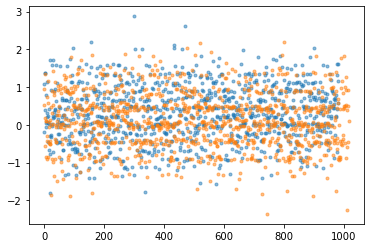

In [82]:
plt.plot(data_test[context_test==1],'.', label='label 1', alpha=0.5)
plt.plot(data_test[context_test==0],'.', label='label 0', alpha=0.5)

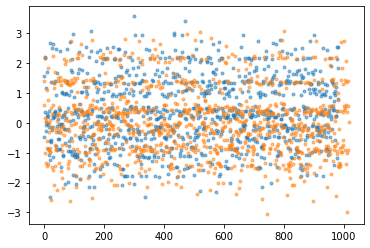

In [83]:
plt.plot(embedding_data_test[embedding_context_test==1],'.', label='label 1', alpha=0.5)
plt.plot(embedding_data_test[embedding_context_test==0],'.', label='label 0', alpha=0.5)

In [85]:
Fair.gamma

0.9